In [1]:
try:
  import torch
  import torcchvision
  assert int(torch.__version__.split(".")) >=12, "torch veraion should be 1.12+"
  assert int(torchvision.__version__.split(".")) >=0.13, "torchvision version should be 0.13+"
  print(f"torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision version not correct")
  !pip3 install -U torch torchvision
  import torch
  import torchvision
  print(f"torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

[INFO] torch/torchvision version not correct
torch version:2.5.1+cu121
torchvision version:0.20.1+cu121


In [4]:
import torch
import matplotlib
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
import nibabel as nib
import numpy as np

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
import nibabel as nib
import numpy as np

subjetos = ["sub-RC4101", "sub-RC4103", "sub-RC4106", "sub-RC4107"]
sesiones = ["ses-1", "ses-2"]
imag_norm = []
for sujeto in subjetos:
    for sesion in sesiones:
        ruta = f"drive/MyDrive/Colab Notebooks/output/derivatives/preprocessed/{sujeto}/{sesion}/anat/{sujeto}_{sesion}_T1w_brain_registered.nii.gz"
        img1= nib.load(ruta)
        imag_norm.append(img1.shape)

imag_norm


[(91, 109, 91),
 (91, 109, 91),
 (91, 109, 91),
 (91, 109, 91),
 (91, 109, 91),
 (91, 109, 91),
 (91, 109, 91),
 (91, 109, 91)]

In [9]:
import random

base="drive/MyDrive/Colab Notebooks/output/derivatives/preprocessed"
imag_dir = []
for sujeto in subjetos:
  for sesion in sesiones:
    ruta = f"{base}/{sujeto}/{sesion}/anat/{sujeto}_{sesion}_T1w_brain_registered.nii.gz"
imag_dir.append(ruta)

random.shuffle(imag_dir)
train_ratio = 0.75
train_size = int(len(imag_dir) * train_ratio)
train= imag_dir[:train_size]
test = imag_dir[train_size:]



## Prueba 1

In [14]:
import os
import random
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

subjetos = ["sub-RC4101", "sub-RC4103", "sub-RC4106", "sub-RC4107"]
sesiones = ["ses-1", "ses-2"]
base_path = "drive/MyDrive/Colab Notebooks/output/derivatives/preprocessed"


image_paths = []
for sujeto in subjetos:
    for sesion in sesiones:
        ruta = f"{base_path}/{sujeto}/{sesion}/anat/{sujeto}_{sesion}_T1w_brain_registered.nii.gz"
        image_paths.append(ruta)

random.shuffle(image_paths)

train_ratio = 0.75
train_size = int(len(image_paths) * train_ratio)
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

def load_and_normalize_image(image_path):
    image = nib.load(image_path).get_fdata()
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    image = torch.tensor(image)
    mean = torch.tensor([0.485]).view(1, 1, 1, 1)
    std = torch.tensor([0.229]).view(1, 1, 1, 1)
    image = (image - mean) / std

    return image

train_images = torch.stack([load_and_normalize_image(p) for p in train_paths])
test_images = torch.stack([load_and_normalize_image(p) for p in test_paths])

batch_size = 1

train_dataloader = DataLoader(TensorDataset(train_images), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_images), batch_size=batch_size, shuffle=False)
for batch in train_dataloader:
  print(f"Tamaño del batch de entrenamiento: {batch[0].shape}")
for batch in test_dataloader:
  print(f"Tamaño del batch de prueba: {batch[0].shape}")
train_dataloader, test_dataloader

Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de entrenamiento: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de prueba: torch.Size([1, 1, 91, 109, 91])
Tamaño del batch de prueba: torch.Size([1, 1, 91, 109, 91])


(<torch.utils.data.dataloader.DataLoader at 0x7b5dd7c9d8a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b5dd7c9f8e0>)

## Prueba 2

# Carga de datos 

In [74]:
import os
import random
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from utils.normalización import search_paths
from tqdm import tqdm

workers = os.cpu_count()

def set_seed(seed: int=23):
    """
    Sets a specific seed for the tests
    
    Args:
        seed (int, optional): Random seed to set. Defaults is 23.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

files = search_paths("output/", "brain_normalized.nii.gz")

labels = [random.randint(0, 1) for _ in range(len(files))]

class BrainDataset(torch.utils.data.Dataset):
        def __init__(self, file_paths, labels, transform=None):
            self.file_paths = file_paths
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            image_path = self.file_paths[idx]
            label = self.labels[idx]
            image = nib.load(image_path).get_fdata()
            image = image.astype(np.float32)
            image = np.expand_dims(image, axis=0)
            image = torch.tensor(image)
            if self.transform:
                image = self.transform(image)
            return image, label


brain_dataset = BrainDataset(files, labels)

train_size = int(0.75 * len(brain_dataset))
test_size = len(brain_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(brain_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=workers)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=workers)


for batch in train_dataloader:
    images, labels = batch
    print(f"Tamaño del batch: {images.shape}, Labels: {labels}")
    break

Tamaño del batch: torch.Size([1, 1, 91, 109, 91]), Labels: tensor([0])


In [ ]:
img, label = next(iter(train_dataloader))

## Testing

In [64]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv3d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features= 836352,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [66]:
set_seed()
model_0 = TinyVGG(input_shape=1, hidden_units=64, output_shape=2).to(device)

with torch.inference_mode():
    logit = model_0(img.to(device))
    pred = torch.softmax(logit, dim=1).argmax(dim=1)

pred

tensor([1], device='cuda:0')

## Train and test

In [76]:
def train_func(model: nn.Module, data: torch.utils.data.DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device=device):
    model.eval()
    train_loss, train_acc = 0, 0
    for bathc, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        loss = loss_fn(y_logit, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred = torch.softmax(y_logit, 1).argmax(1)
        train_acc += (y_pred == y).sum().item() / len (y_pred) #We can use another function if we want
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)
    return train_loss, train_acc

In [68]:
def test_func(model: nn.Module, data: DataLoader, loss_fn: nn.Module, device: torch.device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_pred = y_logits.argmax(1)
            test_acc += (y_pred == y).sum().item() / len (y_pred) #We can use another function if we want
    test_loss = test_loss / len(data)
    test_acc = test_acc / len(data)
    return test_loss, test_acc

In [69]:
def train(
        model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
        optimizer: torch.optim.Optimizer, device: torch.device=device, epochs: int =10
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_func(
            model,train_data,loss_fn,optimizer
        )
        test_loss, test_acc = test_func(
            model, test_data, loss_fn
        )
        print(
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} "
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [82]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [85]:
epochs = 5
model_0_results = train(model_0, test_dataloader, train_dataloader, loss_fn, optimizer,epochs=epochs)
torch.cuda.empty_cache()

 20%|██        | 1/5 [00:03<00:13,  3.49s/it]

Epoch 1 |train_loss : 0.7302 |train_acc : 0.6667 |test_loss : 0.7989 |test_acc : 0.5000 


 40%|████      | 2/5 [00:07<00:10,  3.51s/it]

Epoch 2 |train_loss : 0.6906 |train_acc : 0.6667 |test_loss : 0.7021 |test_acc : 0.5000 


 60%|██████    | 3/5 [00:10<00:07,  3.50s/it]

Epoch 3 |train_loss : 0.6825 |train_acc : 0.6667 |test_loss : 0.7176 |test_acc : 0.5000 


 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

Epoch 4 |train_loss : 0.6585 |train_acc : 0.6667 |test_loss : 0.7302 |test_acc : 0.5000 


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

Epoch 5 |train_loss : 0.6906 |train_acc : 0.6667 |test_loss : 0.7055 |test_acc : 0.5000 


In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [80]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

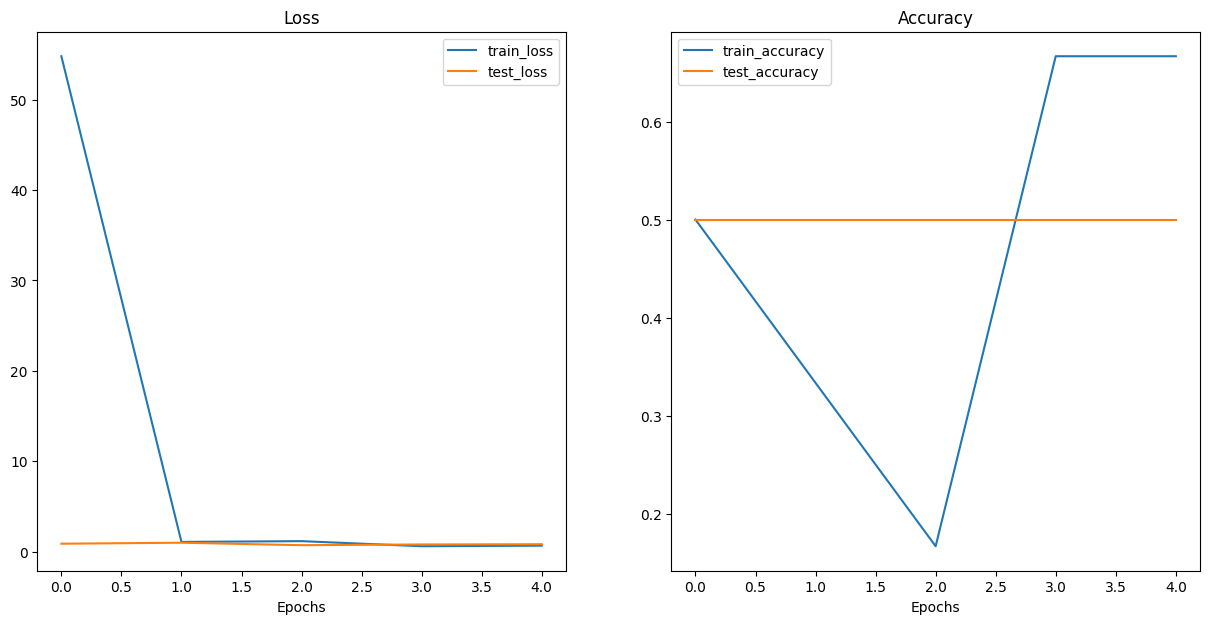

In [84]:
plot_loss_curves(model_0_results)

In [15]:
import nibabel as nib
import torch
import numpy as np
import random from torch.utils.data import DataLoader, TensorDataset

def load_and_normalize_image(image_path):
    image = nib.load(image_path).get_fdata()
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    image = torch.tensor(image)
    mean = torch.tensor([0.485]).view(1, 1, 1, 1, 1)
    std = torch.tensor([0.229]).view(1, 1, 1, 1, 1)
    image = (image - mean) / std
    return image

subjetos = ["sub-RC4101", "sub-RC4103", "sub-RC4106", "sub-RC4107"]
sesiones = ["ses-1", "ses-2"]
base_path = "drive/MyDrive/Colab Notebooks/output/derivatives/preprocessed"

image_paths = []
for sujeto in subjetos:
    for sesion in sesiones:
        ruta = f"{base_path}/{sujeto}/{sesion}/anat/{sujeto}_{sesion}_T1w_brain_registered.nii.gz"
        image_paths.append(ruta)

random.shuffle(image_paths)

train_ratio = 0.75
train_size = int(len(image_paths) * train_ratio)
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

train_images = torch.stack([load_and_normalize_image(p) for p in train_paths])
test_images = torch.stack([load_and_normalize_image(p) for p in test_paths])

train_labels = torch.tensor([random.randint(0, 1) for _ in train_paths], dtype=torch.long)
test_labels = torch.tensor([random.randint(0, 1) for _ in test_paths], dtype=torch.long)

batch_size = 1

train_dataloader = DataLoader(TensorDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_images, test_labels), batch_size=batch_size, shuffle=False)

for batch in train_dataloader:
    print(f"Tamaño del batch de entrenamiento: {batch[0].shape}")
    break

for batch in test_dataloader:
    print(f"Tamaño del batch de prueba: {batch[0].shape}")
    break

train_dataloader, test_dataloader



In [ ]:
import torch.nn as nn
import torch.optim as optim

model_dict = { 'efficientnet_b0': (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.DEFAULT, 1280),
              'vgg16': (torchvision.models.vgg16, torchvision.models.VGG16_Weights.DEFAULT, 25088),
               'vgg19': (torchvision.models.vgg19, torchvision.models.VGG19_Weights.DEFAULT, 25088) }
def prepare_model(model_name):
    model_fn, weights, in_features = model_dict[model_name]
    model = model_fn(weights=weights)
    model.features[0][0] = nn.Conv3d(
        in_channels=1,
        out_channels=model.features[0][0].out_channels,
        kernel_size=model.features[0][0].kernel_size,
        stride=model.features[0][0].stride,
        padding=model.features[0][0].padding,
        bias=False
    )

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features=in_features, out_features=2)  # 2 salidas para las dos clases
    )

    return model



In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return model

def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seeds()

model_names = ['efficientnet_b0', 'vgg16', 'vgg19']
num_epochs = 5
criterion = nn.CrossEntropyLoss()

for model_name in model_names:
    print(f"Preparando y entrenando el modelo: {model_name}")
    model = prepare_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model = train_model(model, train_dataloader, criterion, optimizer, num_epochs)
    print(f"Entrenamiento del modelo {model_name} completado.\n")
